In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from xgboost import XGBClassifier
from sklearn import pipeline as pl
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn import model_selection, metrics
from cross_val_custom import cross_validation_score_statement
from tqdm import tqdm

Загружу данные для обучения модели.

In [2]:
train_data = pd.read_csv('orange_small_churn_train_data.csv',index_col='ID')
train_data['labels'] = train_data['labels'].apply(lambda x: 0 if x == -1 else 1)
labels = train_data['labels'].to_numpy()

Составлю массив индексов признаков и удалю из него индексы тех признаков, которые имеют только одно значение или все значения которых только nan, а также признаки, которые линейно зависят от других признаков.

In [3]:
indices = np.arange(230)
indices = indices[~(train_data.iloc[:,:-1].isnull().all() + train_data.iloc[:,:-1].nunique() == 1)]
line_dependent = np.array([65,155,90,147,127,104,221,213])
indices = np.setdiff1d(indices, line_dependent)

Напишу функцию, разбивающую индексы признаков на индексы числовых признаков и индексы категориальных признаков. Воспользуюсь знанием, что в изначальном наборе данных первые 190 признаков числовые, а последующие категориальные.

In [4]:
def split_indices_of_feature(indices):
    """ Split indices on indices of numerical features and indices of categorial features.
    
        Keyword arguments:
            indices -- 1-d array
        Returns:
            numeric indices -- 1-d array, consisting of indexes of numerical features.
            categoric indices -- 1-d array, consisting of indexes of categorical features.
    """
    return (indices[indices < 190], indices[indices>=190])

Разобью массив на индексы числовых и категориальных признаков.

In [5]:
num_indices, cat_indices = split_indices_of_feature(indices)

Напишу функцию, которая будет вычислять следующие метрики: auc, precission, recall, f-мера. Метрики будут вычиляться на кросс-валидации. Будет использоваться разбиение stratifiedKFold с разбиением на 5 фолдов. Таких разбиений будет 10 штук (для получения более точной оценки). В итоге будет сделано 50 оценок.

In [6]:
def get_cross_val_scores(estimator,data,labels):
    """ Evaluate the following merics: auc, precission, recall and f1 by Stratified 5-Folds cross-validation

        Keyword arguments:
            estimator -- estimator object implementing ‘fit’

            data -- array-like of shape (n_samples, n_features)
            The data to fit.

            labels -- array-like of shape(n_samples)
            The target variable to try to predict.
        Returns:
            auc_scores -- 1-d array of shape (50,) 
            Array of auc scores of the estimator for each run of the cross validation.
            f_scores -- 1-d array of shape (50,) 
            Array of f1 scores of the estimator for each run of the cross validation.
            pr_scores -- 1-d array of shape (50,) 
            Array of precission scores of the estimator for each run of the cross validation.
            rec_scores -- 1-d array of shape (50,) 
            Array of recall scores of the estimator for each run of the cross validation.
    """
    auc_scores = []
    thresholds = []
    pr_scores = []
    rec_scores = []
    f_scores = []
    for i in range(10):
        skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        for train_indices, test_indices in skf.split(data, labels):
            estimator.fit(data[train_indices,:], labels[train_indices])
            auc_scores.append(metrics.roc_auc_score(labels[test_indices], 
                                        estimator.predict_proba(data[test_indices,:])[:,1]))

            fpr, tpr, thr = metrics.roc_curve(labels[test_indices], 
                                        estimator.predict_proba(data[test_indices,:])[:,1])
            norms = np.array([(np.linalg.norm([0,1] - np.array([f, t]))) for t, f in zip(tpr,fpr)])
            thresholds.append(thr[np.argmin(norms)])

            f_scores.append(metrics.f1_score(labels[test_indices],
                                   [0 if p <thr[np.argmin(norms)] else 1 
                                    for p in estimator.predict_proba(data[test_indices,:])[:,1]]))
            pr_scores.append(metrics.precision_score(labels[test_indices],
                                   [0 if p <thr[np.argmin(norms)] else 1 
                                    for p in estimator.predict_proba(data[test_indices,:])[:,1]]))
            rec_scores.append(metrics.recall_score(labels[test_indices],
                                   [0 if p <thr[np.argmin(norms)] else 1 
                                    for p in estimator.predict_proba(data[test_indices,:])[:,1]]))
    return (auc_scores, f_scores, pr_scores, rec_scores)

Построим пайплайн для нашего классификатора. И вычислим среднее метрик, полученных на кроссвалидации. Это будет нашим baseline решением.

In [7]:
xgb_clf = pl.Pipeline(steps=[
    ('feature_processing', pl.FeatureUnion(transformer_list=[
        #numeric
        ('numeric_variable_processing',pl.Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
            ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
            ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
        ])),
        #categorial
        ('categorial_variable_processing',pl.Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
            ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
            ('encoding', ce.CountEncoder(min_group_size=0.1))
        ]))
    ])),
    ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels),n_jobs=4))
])

In [8]:
%%time
auc_scores, pr_scores, rec_score, f_scores = get_cross_val_scores(xgb_clf, train_data.values, labels)

print('Mean of auc scores: %0.4f, mean of precission scores: %0.4f, mean of recall scores: %0.4f, mean of f1 scores: %0.4f' %
     (np.mean(auc_scores), np.mean(pr_scores), np.mean(rec_score), np.mean(f_scores)))

Mean of auc scores: 0.7307, mean of precission scores: 0.2414, mean of recall scores: 0.1474, mean of f1 scores: 0.6716
Wall time: 2min 18s


Вначале я подбирал гиперпараметры алгоритма, пользуясь GridSearch, но уже в скором времени, начал замечать, что таким образом подобранные параметры не дают мне положительных результатов на отложенной выборке и я имею дело с переобучением на кроссвалидации. В поисках ответа на вопрос как с этим быть, я наткнулся на очень интересную статью https://habr.com/ru/company/ods/blog/336168/ и решил воспользоваться советами автора.

Основные идеи статьи:

1) Делать больше разбиений на кроссвалидации. С помощью изменения random_state можно генерировать различные разбиения. В данном случае у меня 10 разбиений на 5 фолдов. В итоге имеем 50 оценок.

2) Сравнивать качество моделей не проверкой среднего значения, а делая статистический тест. Хорошо подходит стандартный тест Стьюдента для разности средних зависимых выборок.

3) Не учитывать при проверке качества выбросы в данных, так как переобучение происходит при настройке алгоритма на различные выбросы.

4) Выбирать значения не с лучшими показателями, а брать среднее множества с лучшими показателями.

Выбросами будем считать объекты на которых наш базовый алгоритм больше всего ошибается. Так как у нас классификатор, который может предсказывать вероятности меток, то лучшей функцией для измерения ошибки алгоритма является logloss. Ниже я написал функцию, которая вычисляет для каждой метки значение функции ошибки.

In [9]:
def get_logloss(y_true, y_pred_proba):
    return -(y_true*np.log(y_pred_proba) + (1-y_true)*np.log(1-y_pred_proba))

Ниже я вычислил значение ошибки классификатора и построил её распределение.

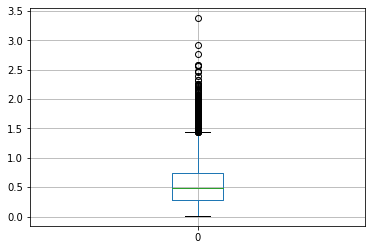

In [10]:
stf_cv = model_selection.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
y_pred = model_selection.cross_val_predict(estimator=xgb_clf, X=train_data.values, y=labels, cv=stf_cv,method='predict_proba')
log_loss_scores = get_logloss(labels, y_pred[:,1])

log_loss_data = pd.DataFrame(log_loss_scores)
log_loss_data.boxplot()

Видно, что значения большие чем 1,4 это выбросы. В дальнейшем можно не проверять качетство алгоритмов на этих объектах.

In [11]:
outsider_mask = log_loss_scores > 1.4
print(len(log_loss_scores[~outsider_mask])/len(log_loss_scores))

0.9743155363681075


На кроссвалидации построим множество оценок auc базового алгоритма для дальнейшего подбора алгоритма.

In [12]:
from cross_val_custom import cross_validation_score_statement
from tqdm import tqdm


base_auc_scores = []

for i in tqdm(range(10)):
    auc_scores = cross_validation_score_statement(estimator=xgb_clf, scoring=metrics.roc_auc_score,
                                                  X=train_data.iloc[:,:-1], y=pd.Series(labels),n_splits=5,
                                             random_state=i,statement=~outsider_mask)
    base_auc_scores = np.append(base_auc_scores, auc_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.39s/it]


Далее я обучу baseline алгоритм и получу оценку на тестовой выборке, чтобы далее иметь возможность сравнивать алгоритмы с настроенными гиперпараметрами на тестовой выборке.

In [13]:
xgb_clf.fit(X=train_data.values, y=labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_variable_processing', Pipeline(memory=None,
     steps=[('selecting', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x0000017B7684A158>, inv_kw_args=None,
  ...a=1, scale_pos_weight=12.279390420899855, seed=None,
       silent=None, subsample=1, verbosity=1))])

In [14]:
churn_test_data = pd.read_csv('orange_small_churn_test_data.csv', index_col='ID')
test_data = churn_test_data.to_numpy()

In [16]:
answer = open('answer_proba_baseline.txt','w')
answer.write('Id,result\n')
probabilities = xgb_clf.predict_proba(test_data)[:,1]
for i, p in enumerate(probabilities):
    answer.write('%d, %f \n'%(i, p))
answer.close()

На тестовой выборке оценка baseline решения равна 0.71337. Попытаюсь улучшить этот результат, настроив гиперпараметры. Для начала я подберу количество деревье для learning rate: 0.1, далее параметр min_child_weight и gamma, и, в завершении, с подобранными min_child_weigh и gamma, я подберу оптимальное колличество дерьвеье для learning rate: 0.01.

Начну с подбора оптимального числа деревьев для learning rate: 0.1.

In [17]:
t_stats = []

In [18]:
%%time
from scipy.stats import ttest_rel

for j in tqdm(np.arange(20,100,1)):
    current_scores = []
    
    xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=j,
                                    learning_rate=0.1, max_depth=3))
    ])
    
    
    for i in range(10):
        score_on_this_split = cross_validation_score_statement(xgb_clf_current,
                                                               scoring=metrics.roc_auc_score, n_splits=5, random_state=i,
                                                               X=pd.DataFrame(train_data.values), y=pd.Series(labels),
                                                               statement=~outsider_mask)
        current_scores = np.append(current_scores,score_on_this_split)
        
    t, p_value = ttest_rel(current_scores, base_auc_scores)
    t_stats = np.append(t_stats, t)

100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [1:43:39<00:00, 77.74s/it]

Wall time: 1h 43min 39s


In [19]:
t_stats = np.append(t_stats, 0)
for j in tqdm(np.arange(101,150,1)):
    current_scores = []
    
    xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=j,
                                    learning_rate=0.1, max_depth=3))
    ])
    
    
    for i in range(10):
        score_on_this_split = cross_validation_score_statement(xgb_clf_current,
                                                               scoring=metrics.roc_auc_score, n_splits=5, random_state=i,
                                                               X=pd.DataFrame(train_data.values), y=pd.Series(labels),
                                                               statement=~outsider_mask)
        current_scores = np.append(current_scores,score_on_this_split)
        
    t, p_value = ttest_rel(current_scores, base_auc_scores)
    t_stats = np.append(t_stats, t)

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [1:35:30<00:00, 116.95s/it]


Text(0, 0.5, 't_stats')

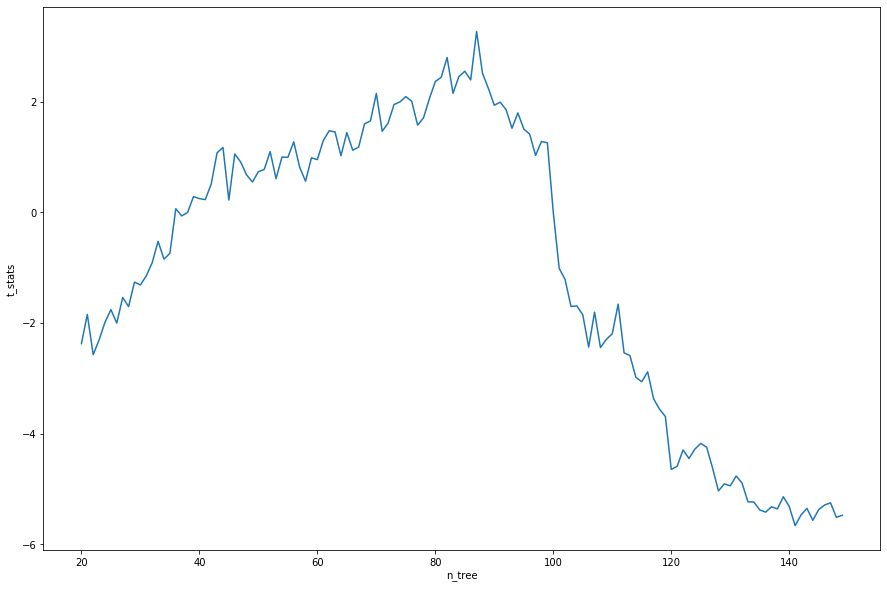

In [24]:
from matplotlib import pylab
%matplotlib inline

pylab.figure(figsize=(15,10))
pylab.plot(np.arange(20,150,1),t_stats)
pylab.xlabel('n_tree')
pylab.ylabel('t_stats')

На графике видно, что лучшие результат где-то на множестве 80 - 90 деревьев. Ниже я рассмотрю этот отрезок поближе.

Text(0, 0.5, 't_stats')

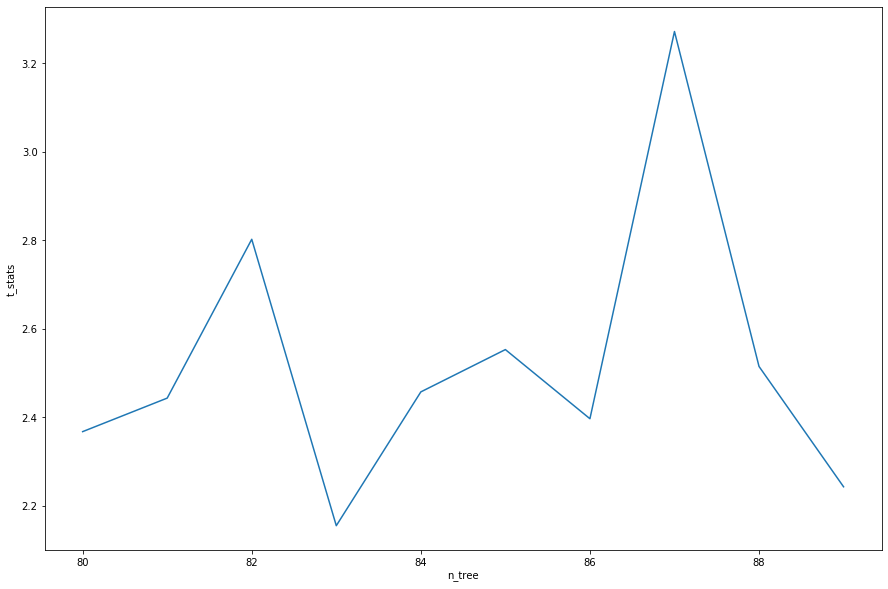

In [23]:
from matplotlib import pylab
%matplotlib inline

pylab.figure(figsize=(15,10))
pylab.plot(np.arange(80,90,1),t_stats[80-20:90-20])
pylab.xlabel('n_tree')
pylab.ylabel('t_stats')

Пользуясь советом, что выбирать нужно не лучший, а средний результат, выберу число в 85 деревьев.

In [27]:
xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=85,
                                    learning_rate=0.1,max_depth=3))
    ])

На кроссвалидации видно, что среднее метрик стало немного лучше.

In [28]:
auc_scores, f_scores, pr_scores,rec_scores = get_cross_val_scores(xgb_clf_current,train_data.values,labels)
print('auc_scores = %0.4f, f_scores = %0.4f, pr_scores = %0.4f, rec_scores = %0.4f' %
     (np.mean(auc_scores), np.mean(f_scores), np.mean(pr_scores), np.mean(rec_scores)))

auc_scores = 0.7319, f_scores = 0.2429, pr_scores = 0.1486, rec_scores = 0.6689


Далее подберу параметр min_child_weight на множестве от 1 до 100.

In [49]:
%%time
#t_stats = []
from scipy.stats import ttest_rel

for j in tqdm(np.arange(150,200,1)):
    current_scores = []
    
    xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=85,
                                    learning_rate=0.1, max_depth=3, min_child_weight=j))
    ])
    
    
    for i in range(10):
        score_on_this_split = cross_validation_score_statement(xgb_clf_current,
                                                               scoring=metrics.roc_auc_score, n_splits=5, random_state=i,
                                                               X=pd.DataFrame(train_data.values), y=pd.Series(labels),
                                                               statement=~outsider_mask)
        current_scores = np.append(current_scores,score_on_this_split)
        
    t, p_value = ttest_rel(current_scores, base_auc_scores)
    t_stats = np.append(t_stats, t)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:17:29<00:00, 93.00s/it]

Wall time: 1h 17min 29s


Text(0, 0.5, 't_stats')

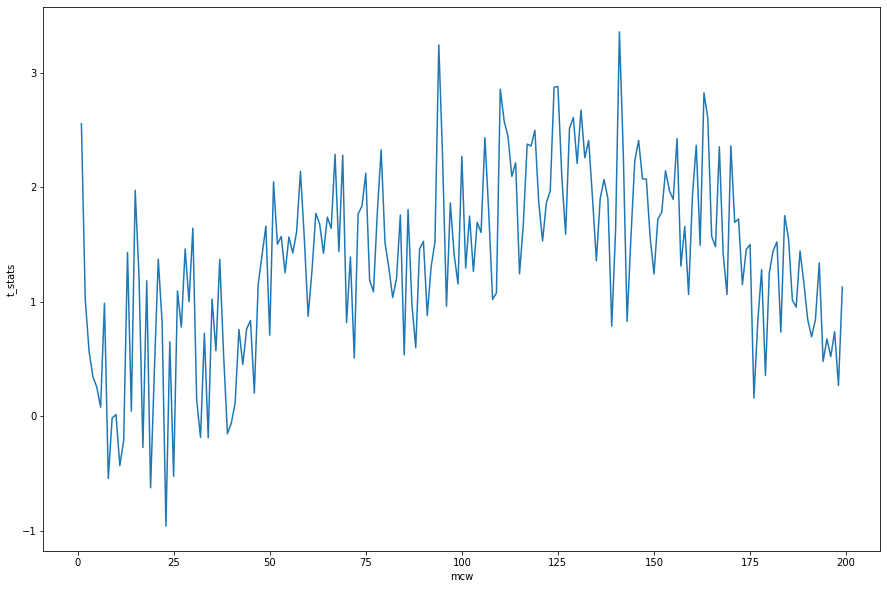

In [50]:
from matplotlib import pylab
%matplotlib inline

pylab.figure(figsize=(15,10))
pylab.plot(np.arange(1,200,1),t_stats[1-1:200-1])
pylab.xlabel('mcw')
pylab.ylabel('t_stats')

Text(0, 0.5, 't_stats')

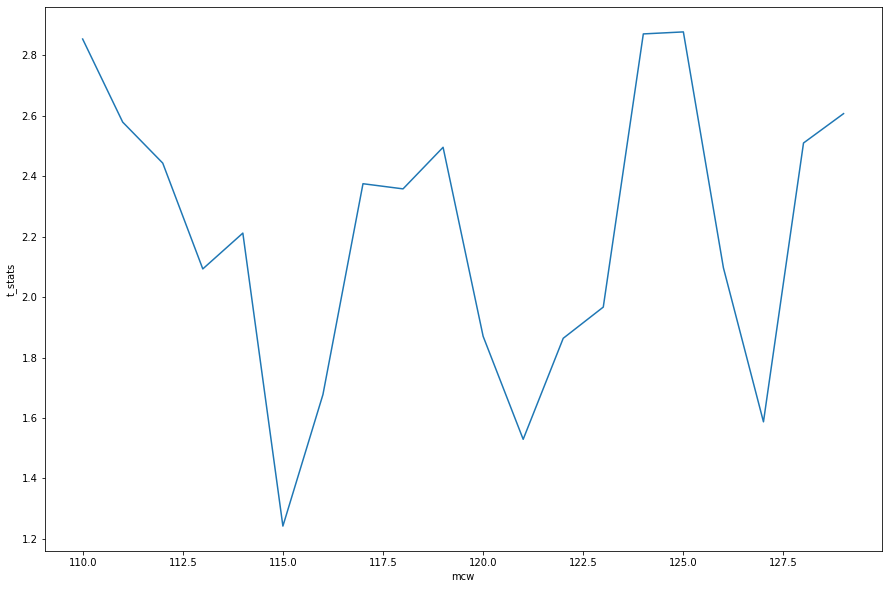

In [52]:
from matplotlib import pylab
%matplotlib inline

pylab.figure(figsize=(15,10))
pylab.plot(np.arange(110,130,1),t_stats[110-1:130-1])
pylab.xlabel('mcw')
pylab.ylabel('t_stats')

Лучший результат на множетсве от 60 до 70. Возьму среднее значение: 66.

In [53]:
xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=85,
                                    learning_rate=0.1, min_child_weight=120,max_depth=3))
    ])

На кроссвалидации видно, что результат стал еще лучше.

In [54]:
auc_scores, f_scores, pr_scores,rec_scores = get_cross_val_scores(xgb_clf_current,train_data.values,labels)
print('auc_scores = %0.4f, f_scores = %0.4f, pr_scores = %0.4f, rec_scores = %0.4f' %
     (np.mean(auc_scores), np.mean(f_scores), np.mean(pr_scores), np.mean(rec_scores)))

auc_scores = 0.7360, f_scores = 0.2467, pr_scores = 0.1515, rec_scores = 0.6679


Теперь можно подобрать и параметр гамма. Я его буду подбирать на множестве от 1 до 70.

In [64]:
%%time
from scipy.stats import ttest_rel
t_stats = []
for j in tqdm(np.arange(1,70,1)):
    current_scores = []
    
    xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=85,
                                    learning_rate=0.1, max_depth=3, min_child_weight=120,gamma=j))
    ])
    
    
    for i in range(10):
        score_on_this_split = cross_validation_score_statement(xgb_clf_current,
                                                               scoring=metrics.roc_auc_score, n_splits=5, random_state=i,
                                                               X=pd.DataFrame(train_data.values), y=pd.Series(labels),
                                                               statement=~outsider_mask)
        current_scores = np.append(current_scores,score_on_this_split)
        
    t, p_value = ttest_rel(current_scores, base_auc_scores)
    t_stats = np.append(t_stats, t)

100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [1:53:48<00:00, 98.96s/it]

Wall time: 1h 53min 48s


Text(0, 0.5, 't_stats')

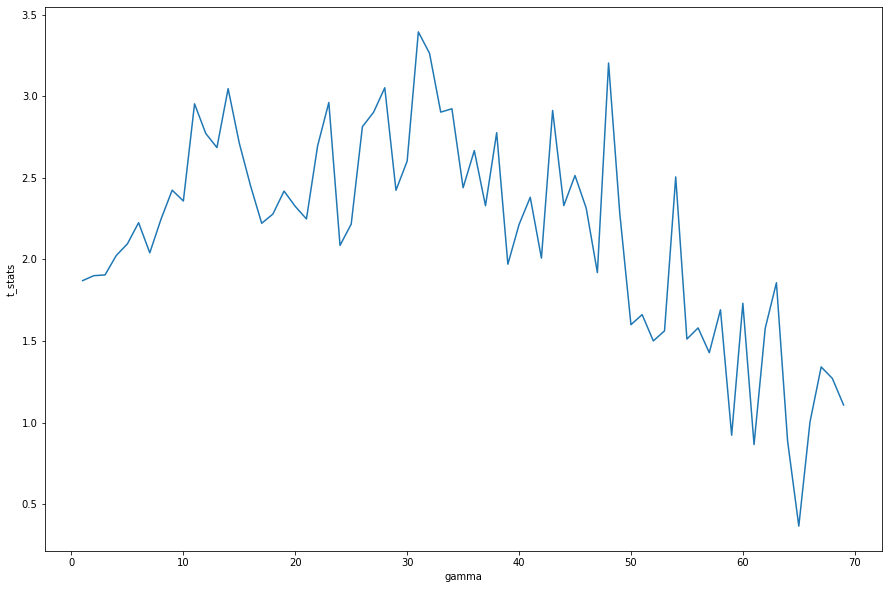

In [65]:
from matplotlib import pylab
%matplotlib inline

pylab.figure(figsize=(15,10))
pylab.plot(np.arange(1,70,1),t_stats[1-1:70-1])
pylab.xlabel('gamma')
pylab.ylabel('t_stats')

Text(0, 0.5, 't_stats')

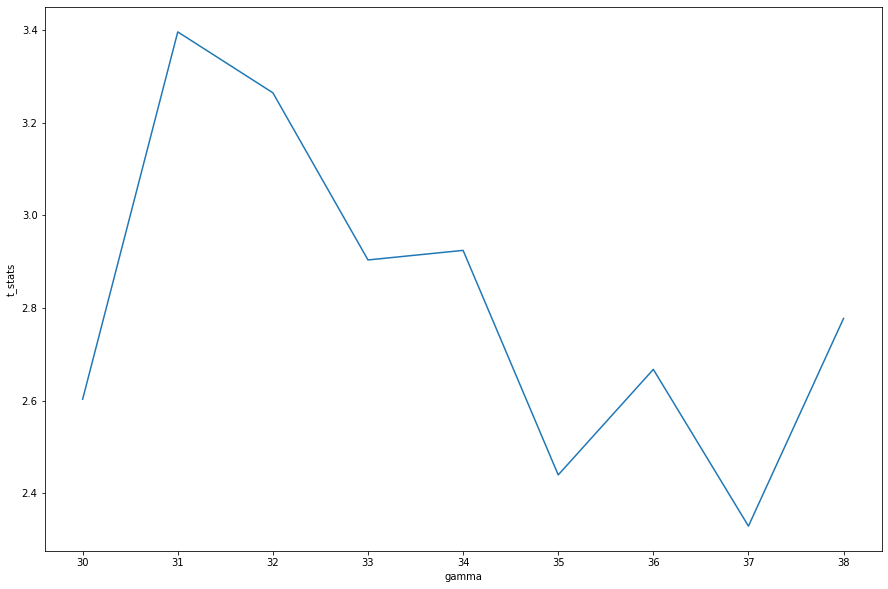

In [67]:
from matplotlib import pylab
%matplotlib inline

pylab.figure(figsize=(15,10))
pylab.plot(np.arange(30,39,1),t_stats[30-1:39-1])
pylab.xlabel('gamma')
pylab.ylabel('t_stats')

In [74]:
xgb_clf_current = pl.Pipeline(steps=[
        ('feature_processing', pl.FeatureUnion(transformer_list=[
            #numeric
            ('numeric_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,num_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=0)),
                ('converting', FunctionTransformer(lambda data: data.astype(np.float64),validate=False))
            ])),
            #categorial
            ('categorial_variable_processing',pl.Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data[:,cat_indices],validate=False)),
                ('imputing_nan_values', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='na')),
                ('encoding', ce.CountEncoder(min_group_size=0.1))
            ]))
        ])),
        ('classifier', XGBClassifier(scale_pos_weight=(len(labels)-sum(labels))/sum(labels), n_jobs=4, n_estimators=85,
                                    learning_rate=0.1, min_child_weight=120, gamma=32,max_depth=3))
    ])

По кроссвалидации видно, что среднее стало еще немного лучше.

In [75]:
auc_scores, f_scores, pr_scores,rec_scores = get_cross_val_scores(xgb_clf_current,train_data.values,labels)
print('auc_scores = %0.4f, f_scores = %0.4f, pr_scores = %0.4f, rec_scores = %0.4f' %
     (np.mean(auc_scores), np.mean(f_scores), np.mean(pr_scores), np.mean(rec_scores)))

auc_scores = 0.7364, f_scores = 0.2459, pr_scores = 0.1506, rec_scores = 0.6749


Проверю качество модели на тестовой выборке.

In [76]:
xgb_clf_current.fit(X=train_data.values,y=labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_variable_processing', Pipeline(memory=None,
     steps=[('selecting', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x0000017B06DC47B8>, inv_kw_args=None,
  ...a=1, scale_pos_weight=12.279390420899855, seed=None,
       silent=None, subsample=1, verbosity=1))])

In [77]:
answer = open('answer_proba_lr_0.1_t_85_mcw_120_gamma_32.txt','w')
answer.write('Id,result\n')
probabilities = xgb_clf_current.predict_proba(test_data)[:,1]
for i, p in enumerate(probabilities):
    answer.write('%d, %f \n'%(i, p))
answer.close()

На тестовой выборке получился результат: 0,71734. Получилось улучшить результат бейзлайна. Далее я хочу усложнить модель и подобрать оптимальное число деревьев для learning_rate: 0.01.